In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from reachability.envs.workspace import Workspace2D
from reachability.envs.rotary_nlink import RotaryNLinkEnv
import time

## Testing environment setup

(1, 6)


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=250.1° | EE Delta=0.0000'}, xlabel='X (World)', ylabel='Y (World)'>

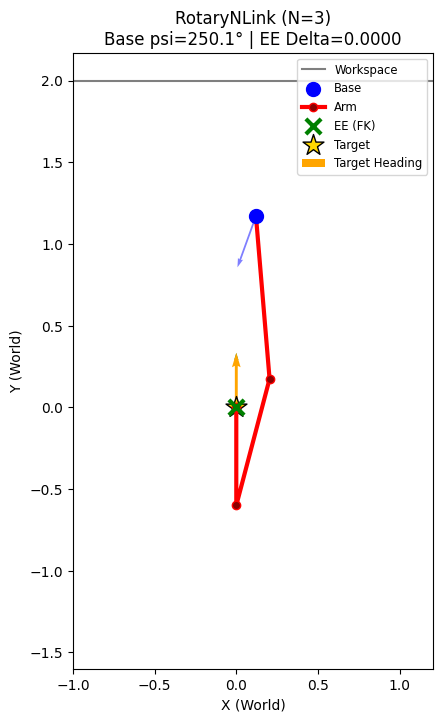

In [83]:
workspace = Workspace2D(-2, 2, -2, 2)
link_lengths = np.array([1.0, 0.8, 0.6])
joint_limits = np.array([[-np.pi/2, np.pi/2], [-np.pi/3, np.pi/2], [-np.pi, np.pi]])
env = RotaryNLinkEnv(workspace, link_lengths=link_lengths, joint_limits=joint_limits, n_links=3) #joint_limits=[[-np.pi, np.pi], [-np.pi, np.pi]],

rng = np.random.default_rng(0)
h_world = np.array([[0, 0, np.pi/2]], dtype=np.float32)
q_sample_world = env.sample_q_given_h_uniform(h_world, rng)

print(q_sample_world.shape)
env.plot(q_sample_world.flatten(), h_world.flatten())

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data_distribution(bx, by, psi, thetas, n_samples=None, theta_names=None, max_points=20000):
    """
    bx, by, psi: (N,) arrays
    thetas: either
      - list/tuple of arrays [th1, th2, ...] each (N,)
      - OR a 2D array shape (N, K)
    n_samples: optional (used only for arrow skipping); if None inferred from bx
    theta_names: optional list of length K (e.g., ["θ1", "θ2", "θ3"])
    max_points: subsample scatter to keep plots fast/legible
    """
    bx = np.asarray(bx).reshape(-1)
    by = np.asarray(by).reshape(-1)
    psi = np.asarray(psi).reshape(-1)

    # Normalize/parse thetas into (N, K)
    if isinstance(thetas, (list, tuple)):
        thetas = [np.asarray(t).reshape(-1) for t in thetas]
        T = np.stack(thetas, axis=1)  # (N, K)
    else:
        T = np.asarray(thetas)
        if T.ndim != 2:
            raise ValueError("thetas must be a list of (N,) arrays or an (N, K) array")
    N, K = T.shape

    if n_samples is None:
        n_samples = N

    if theta_names is None:
        theta_names = [f"θ{i+1}" for i in range(K)]
    if len(theta_names) != K:
        raise ValueError("theta_names must have length K")

    # Subsample for scatter-heavy plots
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)
        bx_s, by_s, psi_s = bx[idx], by[idx], psi[idx]
        T_s = T[idx]
        N_s = max_points
    else:
        bx_s, by_s, psi_s = bx, by, psi
        T_s = T
        N_s = N

    # ---- Figure 1: base distribution ----
    fig1, ax1 = plt.subplots(1, 1, figsize=(8, 7))
    ax1.scatter(bx_s, by_s, s=1, alpha=0.5, color='blue', label="Base Positions")

    # orientation arrows subset
    skip = max(1, N_s // 100)  # ~100 arrows
    ax1.quiver(
        bx_s[::skip], by_s[::skip],
        np.cos(psi_s[::skip]), np.sin(psi_s[::skip]),
        color='red', scale=15, width=0.005, label="Orientation (ψ)"
    )

    ax1.scatter([0], [0], marker="*", s=200, color='gold', edgecolor='black',
                zorder=5, label="Target H=(0,0)")

    ax1.set_aspect('equal')
    ax1.set_title("Base Distribution (donut)")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.legend()
    fig1.tight_layout()

    # ---- Figure 2: joint-mode matrix across all thetas ----
    ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    ticklabels = ['-π', '-π/2', '0', 'π/2', 'π']

    fig2, axes = plt.subplots(K, K, figsize=(3.2*K, 3.2*K), sharex=True, sharey=True)

    # If K==1, axes isn't 2D
    if K == 1:
        axes = np.array([[axes]])

    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            ax.set_xlim(-np.pi, np.pi)
            ax.set_ylim(-np.pi, np.pi)

            if i == j:
                # diagonal: 1D marginal histogram of θ_i
                ax.hist(T_s[:, i], bins=50)
                ax.set_ylabel("")  # keep clean
            elif i > j:
                # lower triangle: leave blank (or could mirror)
                ax.axis("off")
            else:
                # upper triangle: scatter θ_j (x) vs θ_i (y)
                ax.scatter(T_s[:, j], T_s[:, i], s=3, alpha=0.35)

            # labels only on outer edges
            if i == K - 1 and j >= i:
                ax.set_xticks(ticks)
                ax.set_xticklabels(ticklabels)
            else:
                ax.set_xticks([])
            if j == 0 and i <= j:
                ax.set_yticks(ticks)
                ax.set_yticklabels(ticklabels)
            else:
                ax.set_yticks([])

            if i == 0 and j >= 0:
                ax.set_title(theta_names[j])
            if j == K - 1 and i >= 0:
                ax.set_ylabel(theta_names[i], rotation=0, labelpad=25)

            ax.grid(True, linestyle='--', alpha=0.25)

    fig2.suptitle("Joint Modes Across All θ (pairwise)", y=1.02)
    fig2.tight_layout()
    plt.show()


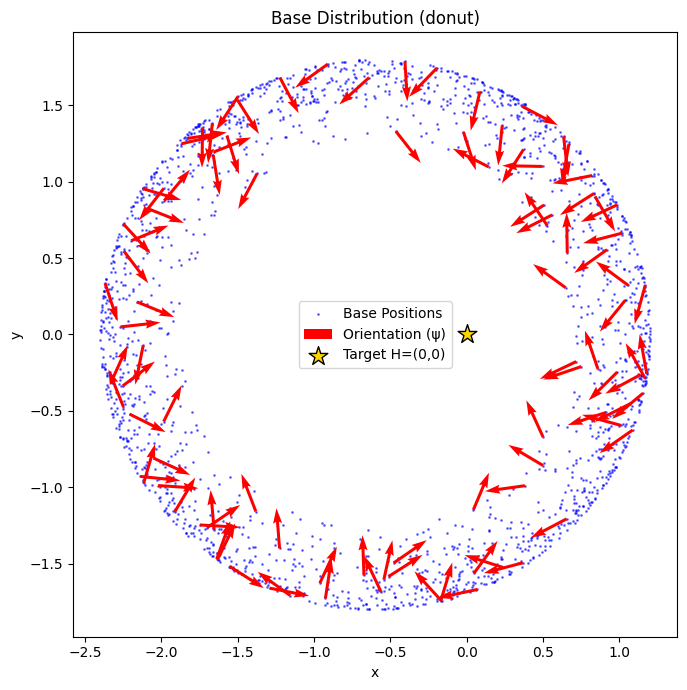

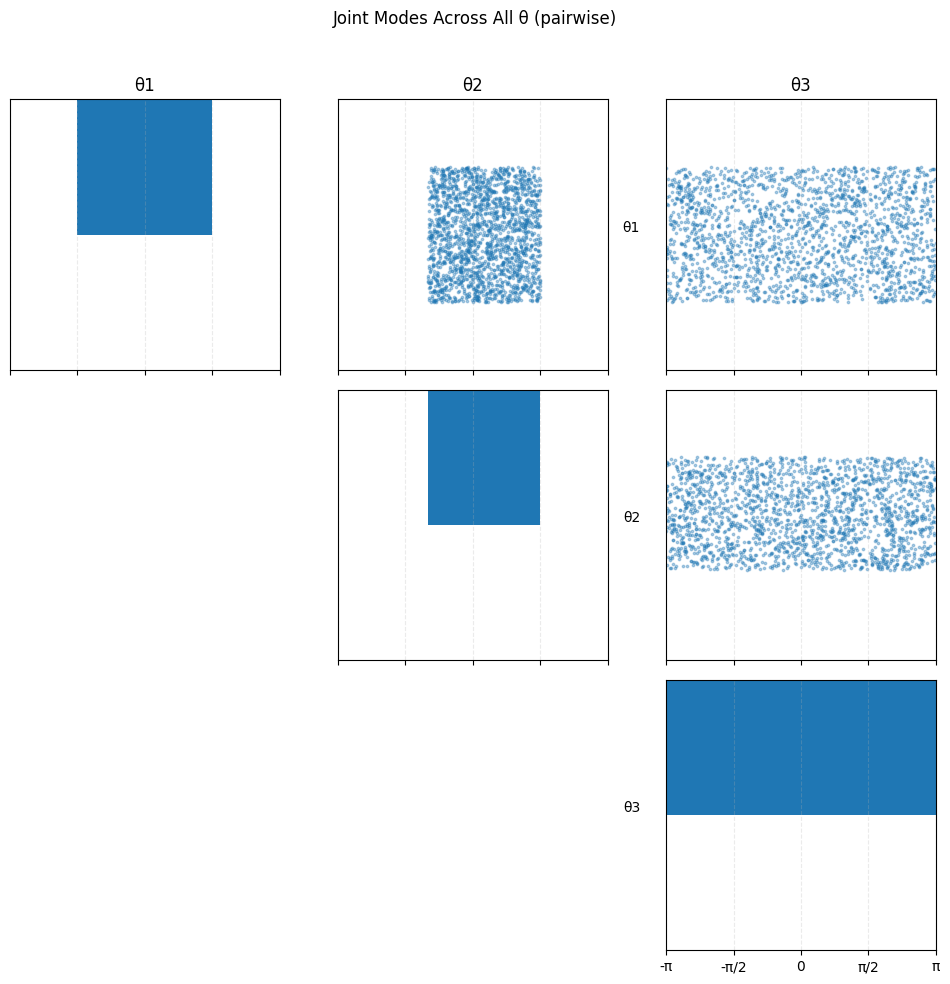

In [85]:
# Data to test on
n_samples = 2000
h_world_example = np.zeros((n_samples, 3), dtype=np.float32)

# 1. Generate 2000 samples for a fixed target at the origin
Q_samples = env.sample_q_given_h_uniform(h_world_example, rng)

# Extract components for plotting -> Q columns: [x, y, psi, th1, th2]
bx = Q_samples[:, 0]
by = Q_samples[:, 1]
psi = Q_samples[:, 2]
thetas = Q_samples[:, 3:]

plot_data_distribution(bx, by, psi, thetas)